# TP3: Apprentissage Statistique - Wine Quality Database
Auteurs: Thomas Levy, Selim Dekali

## Introduction
Nous avons choisi d'analyser des données sur la qualité du vin du type "Vinho Verde" venant du Portugal (https://archive.ics.uci.edu/ml/datasets/wine+quality).
La qualité du vin est donnée sur une échelle de 0 à 10 ainsi que 11 variables relatives aux vins.

Nous avons choisi d'aborder ce problème en essayant de prédire la qualité exacte du vin en fonction des 11 autres variables. 
Donc, sous forme d'un problème de classification supervisée multi-classes.

**NOTE**: Nous aurions également pu transformer la qualité du vin en un nombre de classes plus réduites (du type: mauvais, moyen, bon). 
Ce qui aurait été un problème probablement plus simple à résoudre mais également moins interessant!


In [2]:
library(randomForest)
library(quantmod)

#install.packages("ggplot2")
library(ggplot2)

#install.packages("outliers")
library(outliers)

#install.packages("adabag")
library(adabag)

## Import et mise en forme des données
Nous récupérons les données

In [3]:
red <- read.csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"), sep = ";")
white <- read.csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"), sep = ";")

red$Color <- "red"
white$Color <- "white"
Wines <- rbind(red, white)

Nous transformons les variables Color et qualité en facteurs afin de pouvoir traiter le problème sous forme de classification.

In [4]:
Wines$quality <- as.factor(Wines$quality)
Wines$Color <- as.factor(Wines$Color)

## Analyse simple des données

In [5]:
summary(Wines)

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.400   1st Qu.:0.2300   1st Qu.:0.2500   1st Qu.: 1.800  
 Median : 7.000   Median :0.2900   Median :0.3100   Median : 3.000  
 Mean   : 7.215   Mean   :0.3397   Mean   :0.3186   Mean   : 5.443  
 3rd Qu.: 7.700   3rd Qu.:0.4000   3rd Qu.:0.3900   3rd Qu.: 8.100  
 Max.   :15.900   Max.   :1.5800   Max.   :1.6600   Max.   :65.800  
                                                                    
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  1.00      Min.   :  6.0        Min.   :0.9871  
 1st Qu.:0.03800   1st Qu.: 17.00      1st Qu.: 77.0        1st Qu.:0.9923  
 Median :0.04700   Median : 29.00      Median :118.0        Median :0.9949  
 Mean   :0.05603   Mean   : 30.53      Mean   :115.7        Mean   :0.9947  
 3rd Qu.:0.06500   3rd Qu.: 41.00      3rd Qu.:156.0        3rd

In [6]:
summary(Wines$quality)

3    4    5    6    7    8    9 
  30  216 2138 2836 1079  193    5

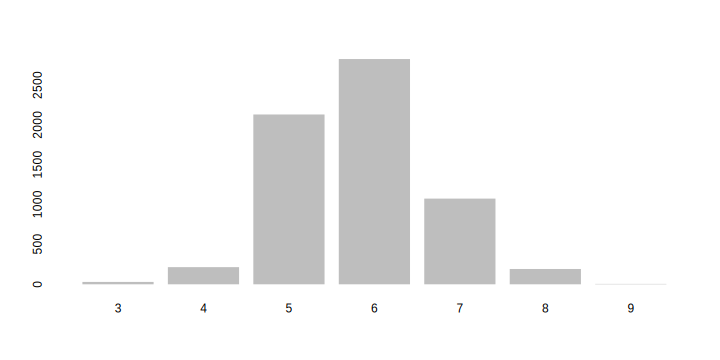

In [7]:
barplot(table(Wines$quality))

On observe que les données de qualité sont très déséquilibrés. 
Il y a majoritairement du vin de qualité moyenne (qualité 6 et 7) mais quasiment pas de vin dont la qualité est:
* soit excellente (9 ou 10) 
* ou trés mauvaise (3 ou moins)

Dans un premier temps, on conserve ces données déséquilibrées mais on verra plus tard si on ne peut pas équilibrer ces données.

## Préparation pour l'apprentissage statistiques
On sépare les données en train & test (75% utilisé pour l'apprentissage)

In [8]:
wine_ind <- sample(nrow(Wines), 0.75 * nrow(Wines))
train <- Wines[wine_ind, ]
test <- Wines[-wine_ind, ]

## Decision Tree
On va essayer un abre de décision en faisant de la cross-validation de type V-fold.


In [9]:
# We use a decision tree
library(rpart)
library(e1071)

In [ ]:
DT_cross <- tune.rpart(quality~., data = train, minsplit = c(2, 3, 5), minbucket= c(1, 3, 5), cp= seq(0.01, 0.1, 0.02),
                       tunecontrol = tune.control(sampling = 'cross', cross = 10))

In [ ]:
DT_cross$best.parameters

In [ ]:
DT_cross$best.performance

La performance du modele avec les hyper-parametres optimaux ne semble pas trés bonne.

On va tester le modele sur nos données de test. 


In [ ]:
rt.quality = rpart(quality ~., data = train, method= "class", minsplit=2, minbucket=1)

In [ ]:
rt.predictions = predict(rt.quality, data = test, type= "class")

In [ ]:
rt.predictions = predict(rt.quality, test, type= "class")
currentError = sum(rt.predictions!=test[,'quality'])/nrow(test)
print(currentError)
summary(rt.predictions)

In [ ]:
conf <- table(rt.predictions, test[,'quality'])
print(conf)

Les résultats de prédictions sont médiocres et le modèle ne prédit que peu de classes (2 ou 3).

## SVM

On va essayer le modele SVM. 
On va faire de la cross-validation pour selectionner les paramétres optimaux parmi:
- la fonction kernel 
- gamma
- cost (le cout de la violation de contrainte)
    
**NOTE**: Il est à noter que SVM intégre la normalisation des variables (donc inutile de le faire en entrée)
    

In [ ]:
SVM_cross <- tune(svm, quality ~., data = train,
                  ranges = list(kernel =c('radial', 'sigmoid', 'linear'),
                                gamma = c(0.5, 1, 2, 4),
                                cost = c(0.1, 1, 10, 100, 1000)),
                  tunecontrol = tune.control(sampling = 'cross', cross = 5))

In [ ]:
SVM_cross$best.performance

In [ ]:
SVM_cross$best.parameters

In [ ]:
svm.model <- svm(quality ~ ., data = train, kernel='radial', cost = 10, gamma = 1)
svm.pred <- predict(svm.model, test)

In [ ]:
table(svm.pred, test$quality)

In [ ]:
currentError = sum(svm.pred!=test[,'quality'])/nrow(test)
print(currentError)

Nous avons trouvé un modèle optimal avec kernel gaussien ("radial"), gamma de 1 et cost 10.

L'erreur de prédiction ést plus faible que précedemment. 
De plus, la matrice de confusion montre que SVM prédit mieux les classes avec un petit nombre d'observation que ce que nous avons testé au préalable.
 

## KNN
Nous allons également essayé le modèle kNN.
Cette fois, il est utile de normaliser les variables.

In [54]:
library(outliers)
Data_normalized <- subset(Wines, select = -c(quality, Color))
Data_normalized <- scores(Data_normalized)
Data_normalized$quality <- Wines$quality

In [55]:
train_s <- Data_normalized[wine_ind, ]
test_s <- Data_normalized[-wine_ind, ]

In [56]:
y.train_s <- train_s$quality
train_s$quality <- NULL
x.train_s <- do.call(cbind, train_s)

In [57]:
KNN_cross <- tune.knn(x.train_s, y.train_s, k = 5:50, tunecontrol = tune.control(sampling = 'cross', cross = 10))

In [58]:
KNN_cross$best.performance

[1] 0.4427328

In [59]:
KNN_cross$best.parameters

,k
13,17


In [ ]:
La valeur optimale obtenue pour k est 17.
On utilisera cette valeur par la suite.

In [60]:
y.test_s <- test_s$quality
test_s$quality <- NULL
x.test_s <- do.call(cbind, test_s)

In [61]:
library(class)
knn.pred<-knn(x.train_s, x.test_s, y.train_s, k = 17)

In [62]:
table(knn.pred, y.test_s)

        y.test_s
knn.pred   3   4   5   6   7   8   9
       3   0   0   0   0   0   0   0
       4   0   1   1   0   0   0   0
       5   3  35 334 156  11   2   0
       6   3  19 190 451 161  24   0
       7   0   0   9  93 101  24   2
       8   0   0   0   1   3   1   0
       9   0   0   0   0   0   0   0

In [63]:
currentError = sum(knn.pred!=y.test_s)/nrow(test)
print(currentError)

[1] 0.4535385



La valeur optimale pour k est 17.

Au final, l'érreur de prédiction est assez importante en kNN.


## Random Forest
On va maintenand essayer un modèle de type foret aléatoire.

In [93]:
library(randomForest)

In [94]:
fit <- randomForest(quality ~., data = train, ntree=500)
print(fit)


Call:
 randomForest(formula = quality ~ ., data = train, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 31.63%
Confusion matrix:
  3  4    5    6   7  8 9 class.error
3 0  0   14    9   0  0 0   1.0000000
4 0 22   80   66   1  0 0   0.8698225
5 0  3 1132  431  13  0 0   0.2830906
6 0  3  316 1687 127  4 0   0.2105756
7 0  0   21  355 435  3 0   0.4656020
8 0  0    1   46  46 55 0   0.6283784
9 0  0    0    1   1  0 0   1.0000000


In [66]:
rf.predictions = predict(fit,test)
summary(rf.predictions)
currentError=sum(rf.predictions!=test[,12])/nrow(test)

#print(currentError)
print(c('Erreur avec random Forest:',currentError))
#Le taux de prediction est meilleur

[1] "Erreur avec random Forest:" "0.312615384615385"         



Random forest est le modèle qui donne l'érreur de prédiction la plus faible.


# Rééquilibrage des données

Nous avons constaté que le jeu de donnée est dééquilibré, principalement sous representation des classes 3 et 9. 

Nous allons utiliser la fonction SMOTE qui combine oversampling de la classe minoritaire et undersampling des autres. Les nouvelles données générées utilisent l'algorithme de plus proches voisins, avec par défaut un k=5.

In [108]:
library(DMwR)

print("Initial training:")
table(train$quality)
#On va essayer de re-equilibrer
train_r <- SMOTE(quality ~., train, perc.over= 1000, perc.under = 4000)
print("After first SMOTE:")
table(train_r$quality)

[1] "Initial training:"



   3    4    5    6    7    8    9 
  23  169 1579 2137  814  148    2 

[1] "After first SMOTE:"



  3   4   5   6   7   8   9 
  6  24 229 380 133  28  22 

On a ré-equilibré la classe 9 (mais toujours pas la classe 3)

In [109]:
train_re <- SMOTE(quality ~., train_r, perc.over= 500, perc.under = 2000)
#newTrain <- SMOTE(quality ~., newTrain,perc.over= 500,k=5, perc.under = 5000)

In [111]:
print("After second SMOTE:")
table(train_re$quality)

#barplot(table(Wines$quality))
#On a ré-equilibré la classe 9 et la classe 3

[1] "After second SMOTE:"



  3   4   5   6   7   8   9 
 36  10 167 287  96  21   9 

Nous obtenons ainsi un échantillon qui est plus équilibré mais dont les nouvelles données générées sur les classes 3 et 9, sont obtenu grace à l'algorithme des plus proches voisins.

Nous allons à présent utiliser les algorithmes étudiés précédemment sur ces données rééquilibrées.

## Random Forest

In [112]:
fit <- randomForest(quality ~., data = train_re, ntree=500)
print(fit)


Call:
 randomForest(formula = quality ~ ., data = train_re, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 19.65%
Confusion matrix:
   3 4   5   6  7  8 9 class.error
3 36 0   0   0  0  0 0   0.0000000
4  0 4   3   3  0  0 0   0.6000000
5  1 0 119  47  0  0 0   0.2874251
6  0 0  17 258 12  0 0   0.1010453
7  0 0   2  28 66  0 0   0.3125000
8  0 0   1   3  6 11 0   0.4761905
9  0 0   0   0  0  0 9   0.0000000


les résultats sur l'échantillon d'entrainement permettent de prédire de façon assez precise les classes précédemment sous representées. Et le taux d'erreur est très faible comparativement au résultats précédent.

In [113]:
rf.predictions <- predict(fit, test)

In [114]:
currentError=sum(rf.predictions!=test[,12])/nrow(test)

#print(currentError)
print(c('Erreur avec random Forest:',currentError))
#Le taux de prediction est meilleur



[1] "Erreur avec random Forest:" "0.486769230769231"         


In [116]:
table(rf.predictions, test$quality )

              
rf.predictions   3   4   5   6   7   8   9
             3   0   0  15   6   0   0   0
             4   0   0   2   0   0   0   0
             5   0  12 214  92   8   1   0
             6   6  34 326 558 196  33   1
             7   1   1   2  40  59   8   2
             8   0   0   0   3   2   3   0
             9   0   0   0   0   0   0   0

Premiere conclusion:
Malgré le ré-equilibrage (avec la méthode smote), les résultats sur l'échantillon de test sont décevant et notamment nettement moins bon que sur la base d'entrainement, ce qui en général est caractéristique d'un cas de surapprentissage.

## SVM

In [115]:
SVM_cross <- tune(svm, quality ~., data = train_re,
                  ranges = list(kernel =c('radial', 'sigmoid'),
                                gamma = c(0.5, 1, 2, 4),
                                cost = c(0.1, 1, 10, 100, 1000)),
                  tunecontrol = tune.control(sampling = 'cross', cross = 5))

In [117]:
SVM_cross$best.performance

[1] 0.2492317

In [118]:
SVM_cross$best.parameters

,kernel,gamma,cost
25,radial,0.5,100


In [119]:
svm.model <- svm(quality ~ ., data = train_re, kernel='radial', cost = 100, gamma = 0.5)
svm.pred <- predict(svm.model, test)

In [120]:
table(svm.pred, test$quality)

        
svm.pred   3   4   5   6   7   8   9
       3   0   0   3   0   0   0   0
       4   0   2   3   0   0   0   0
       5   2  13 188 126  17   0   0
       6   5  30 354 497 167  29   0
       7   0   2   9  70  74  10   3
       8   0   0   2   6   7   6   0
       9   0   0   0   0   0   0   0

In [121]:
currentError = sum(svm.pred!=test[,'quality'])/nrow(test)
print(currentError)

[1] 0.528


Premiere conclusion:
Comme dans le cas des forêts aléatoires, les résultats relativement bon sur la base d'entrainement se dégradent fortement sur la base de test, laissant supposer un problème de surapprentissage.

## KNN

Nous allons à present tester l'algorithme des K plus proches voisins, qui avait obtenu les moins bon résultats sur les données non rééchantillonnées.


In [122]:
library(outliers)

In [124]:
Data_normalized <- subset(Wines, select = -c(quality, Color))

In [125]:
Data_normalized <- scores(Data_normalized)

In [126]:
Data_normalized$quality <- Wines$quality

In [127]:
wine_ind <- sample(nrow(Wines), 0.75 * nrow(Wines))
train_s <- Data_normalized[wine_ind, ]
test_s <- Data_normalized[-wine_ind, ]

In [128]:
y.train_s <- train_s$quality
train_s$quality <- NULL
x.train_s <- do.call(cbind, train_s)

In [129]:
KNN_cross <- tune.knn(x.train_s, y.train_s, k = 5:50, tunecontrol = tune.control(sampling = 'cross', cross = 5))

In [130]:
KNN_cross$best.performance

[1] 0.4519703

In [131]:
KNN_cross$best.parameters

,k
22,26


In [132]:
y.test_s <- test_s$quality
test_s$quality <- NULL
x.test_s <- do.call(cbind, test_s)

In [133]:
library(class)
knn.pred<-knn(x.train_s, x.test_s, y.train_s, k = 26)

In [134]:
table(knn.pred, y.test_s)

        y.test_s
knn.pred   3   4   5   6   7   8   9
       3   0   0   0   0   0   0   0
       4   0   0   0   0   0   0   0
       5   4  39 309 163  14   0   0
       6   1  19 198 492 146  21   0
       7   0   0  12  78 101  26   0
       8   0   0   0   1   1   0   0
       9   0   0   0   0   0   0   0

In [135]:
currentError = sum(knn.pred!=y.test_s)/nrow(x.test_s)
print(currentError)

[1] 0.4449231


Premiere conclusion:
Contrairement au foret aléatoire et SVM les résultats ne diminuent que très faiblement entre l'apprentissage et le teste mais les résultats restent décevant avec des taux d'erreur de plus de 40%, très proches de ceux obtenus sur données brutes.

## Conclusion

Nous avons testé 3 stratégies (KNN, SVM et Random Forest) sur le jeu de données afin de prédire la qualité du vin, en nous plaçant dans un contexte de classification multi-classe. Le jeu de données étant particulièrement déséquilibré, nous avons testé ces stratégies sur le jeu de données "brutes" ainsi que sur des données rééquilibrées.

Nous avons effectué des validations croisées, nous permettant de calibrer nos modèles et ainsi de déterminer leurs performances.
L'algorithme KNN est clairement celui présentant les résultats le plus décevant avec des taux d'erreur au-dessus de 40%. Le k optimal étant assez important il ne permet pas/très mal de capturer les classes sous représentées. 

Le séparateur à vaste marge permet de capturer les relations non linéaires entre les variables explicatives et la qualité du vin, il présente un taux de bonne réponse de l'ordre de 60%, ce qui n'est pas si mal compte tenu de la difficulté de l'exercice.
Enfin, l'algorithme des forêts aléatoires obtient les meilleurs résultats,  notamment sur les classes à faible nombre d’observation (notes 4 et 8). 

Le meilleur taux de prédiction que nous ayons obtenu est de 31% pour le modèle de forêt aléatoire.

Les données étant mal réparties entre les classes, problème classique en apprentissage statistique, nous avons essayé de le rééchantillonner, en utilisant la fonction SMOTE. Nous l’avons appliqué 2 fois de manières successives  ce qui nous a permis d’obtenir un nouvel échantillon d’apprentissage à peu près équilibré. Mais cette fonction qui combine à la fois oversampling et undersampling génère de nouvelles données pour l’oversampling en utilisant l’algorithme des plus proches voisins (avec  k=5, valeur comme défaut). La classe 9 n’ayant que 5 observations les nouvelles données risque d’être légèrement bruitées. Afin d’étudier cet impact nous avons essayé plusieurs valeurs de k, et avons obtenu des résultats relativement similaires (testes non présentés dans le notebook) .


Les résultats obtenus par rééchantillonnage sont assez décevant, on observe une forte augmentation du taux d’erreur entre l’apprentissage et le teste, ce qui nous oriente vers de l’overfitting. Afin d’éviter ce phénomène nous aurions pu mettre en place un rééquilibrage en utilisant juste de l’undersampling mais le faible nombre d’observations de certaines classes, auraient conduit à un jeu de donnée relativement restreint.


De plus, nous avons choisi d'étudier ce problème sous le prisme de la classification, une étude en régréssion nous aurait certainement permis d'afficher de meilleur résultats.


